## Note
In this notebook, i just prepare the data then fine tuning VGG16 to diagnosis pneumonia. If you wanna see insight the dataset, please visit this notebook ---> https://www.kaggle.com/luukhang/build-alexnet-to-classifies-pneumonia.

Transfer learning VGG16 for this dataset, check this out ---> https://www.kaggle.com/luukhang/transfer-learning-vgg16-to-classifies-pneumonia

# 1. Import libs

In [21]:
# Common lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Utils
from tqdm import tqdm
import datetime

# Sklearn
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print("Import successfully")

Import successfully


# 2. Prepare data

In [22]:
# Init variables
input_folder = '../input/coronahack-chest-xraydataset'
test_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'test')
train_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')
metadata_df = pd.read_csv(os.path.join(input_folder, 'Chest_xray_Corona_Metadata.csv'), index_col=0)

In [23]:
# Split to train & test set
train_df = metadata_df[metadata_df.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = metadata_df[metadata_df.Dataset_type == 'TEST'].reset_index(drop=True)

# Check train_df size + test_df size == metadata_df size
assert train_df.size + test_df.size == metadata_df.size

print(f'Shape of train data: { train_df.shape }')
print(f'Shape of test data: { test_df.shape }')

Shape of train data: (5286, 5)
Shape of test data: (624, 5)


In [24]:
# fill na
train_df.fillna('unknow', inplace=True)
test_df.fillna('unknow', inplace=True)

In [25]:
# Image augmentation
train_datagen = ImageDataGenerator(rotation_range=10,
                              brightness_range=(0.1, 1.2),
                              zoom_range=[0.75, 1],
                              horizontal_flip=True)
test_datagen = ImageDataGenerator()

In [26]:
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=42)

In [27]:
train_batches = train_datagen.flow_from_dataframe(train_df,
                                             directory=train_img_folder,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

valid_batches = test_datagen.flow_from_dataframe(valid_df,
                                             directory=train_img_folder,
                                             x_col='X_ray_image_name',
                                             y_col='Label',
                                             class_mode='binary',
                                             batch_size=128)

test_batches = test_datagen.flow_from_dataframe(test_df,
                                            directory=test_img_folder,
                                            x_col='X_ray_image_name',
                                            y_col='Label',
                                            class_mode='binary',
                                            batch_size=8,
                                            shuffle=False)

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [28]:
print(f'Label encode: { valid_batches.class_indices }')

Label encode: {'Normal': 0, 'Pnemonia': 1}


In [29]:
train_batches_series = pd.Series(train_batches.classes)
valid_batches_series = pd.Series(valid_batches.classes)

print(f'Value count in train_batches: \n{ train_batches_series.value_counts() }')
print(f'Value count in valid_batches: \n{ valid_batches_series.value_counts() }')

Value count in train_batches: 
1    3169
0    1059
dtype: int64
Value count in valid_batches: 
1    775
0    283
dtype: int64


# 3. Fine tuning

In [30]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        
create_dir('models')

**Preprocessing layer**

In [31]:
resize_and_rescale = Sequential([
    Resizing(224, 224),
    Rescaling(1./255)
])

In [32]:
metrics = [TruePositives(name='TP'),
           TrueNegatives(name='TN'),
           FalsePositives(name='FP'),
           FalseNegatives(name='FN'),
           AUC(curve='PR', name='AUC')]

In [33]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-81ojj4cs
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-81ojj4cs
  Running command git submodule update --init --recursive -q


In [34]:
from classification_models.keras import Classifiers

In [35]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18((224, 224, 3), weights='imagenet', include_top=False)

In [36]:
# Preprocess layer
ft_resnet18 = Sequential([resize_and_rescale]) 
# Feature extractor
ft_resnet18.add(base_model)
# Classifier
ft_resnet18.add(GlobalAveragePooling2D())
ft_resnet18.add(Dense(1, activation='sigmoid'))

In [37]:
# Freeze
#for layer in ft_resnet34.layers[1].layers[:50]:
#    layer.trainable = False

In [38]:
resnet18_dir = 'models/resnet18'
resnet18_file = 'best_resnet18.hdf5'

create_dir(resnet18_dir)

checkpoint = ModelCheckpoint(os.path.join(resnet18_dir, resnet18_file),
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=30,
                               verbose=1,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), 
                              patience=7, min_delta=1e-3, verbose=1, min_lr=1e-7)

In [39]:
# Initialize TensorBoard
log_dir = 'models/resnet18/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [40]:
epochs = 200
lr = 1e-4

ft_resnet18.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=metrics)

training_time_start = datetime.datetime.now()

resnet18_history = ft_resnet18.fit(train_batches,
                                epochs=epochs,
                                verbose=2,
                                callbacks=[checkpoint, reduce_lr, early_stopping, tensorboard_callback],
                                validation_data=valid_batches,
                                steps_per_epoch=len(train_batches),
                                validation_steps=len(valid_batches))

training_time_end = datetime.datetime.now()

Epoch 1/200
34/34 - 171s - loss: 0.2047 - TP: 2981.0000 - TN: 916.0000 - FP: 143.0000 - FN: 188.0000 - AUC: 0.9903 - val_loss: 0.5847 - val_TP: 775.0000 - val_TN: 0.0000e+00 - val_FP: 283.0000 - val_FN: 0.0000e+00 - val_AUC: 0.6669

Epoch 00001: val_loss improved from inf to 0.58469, saving model to models/resnet18/best_resnet18.hdf5
Epoch 2/200
34/34 - 126s - loss: 0.1108 - TP: 3092.0000 - TN: 967.0000 - FP: 92.0000 - FN: 77.0000 - AUC: 0.9966 - val_loss: 0.6392 - val_TP: 775.0000 - val_TN: 0.0000e+00 - val_FP: 283.0000 - val_FN: 0.0000e+00 - val_AUC: 0.7218

Epoch 00002: val_loss did not improve from 0.58469
Epoch 3/200
34/34 - 124s - loss: 0.0931 - TP: 3095.0000 - TN: 979.0000 - FP: 80.0000 - FN: 74.0000 - AUC: 0.9973 - val_loss: 0.7830 - val_TP: 775.0000 - val_TN: 0.0000e+00 - val_FP: 283.0000 - val_FN: 0.0000e+00 - val_AUC: 0.7273

Epoch 00003: val_loss did not improve from 0.58469
Epoch 4/200
34/34 - 124s - loss: 0.0772 - TP: 3112.0000 - TN: 999.0000 - FP: 60.0000 - FN: 57.0000 -

In [41]:
total_training_seconds = (training_time_end - training_time_start).seconds
print('Total training time: ', str(datetime.timedelta(seconds=total_training_seconds)))

Total training time:  2:02:37


# 4. Evaluate

In [42]:
resnet18_hist_df = pd.DataFrame(resnet18_history.history)

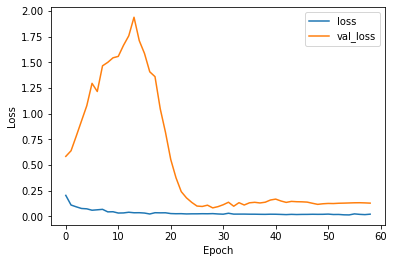

In [54]:
resnet18_hist_df.loc[:, ['loss', 'val_loss']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

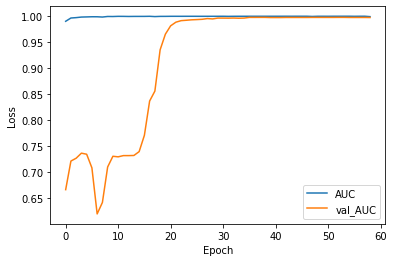

In [55]:
resnet18_hist_df.loc[:, ['AUC', 'val_AUC']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

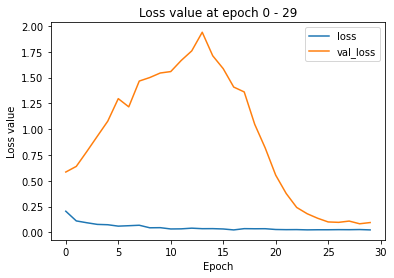

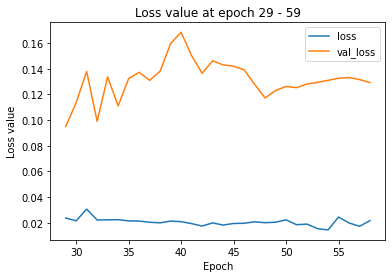

In [46]:
num_of_epochs = resnet18_hist_df.shape[0]
half_epoch = int(num_of_epochs / 2)

first_half_resnet18_hist = resnet18_hist_df.loc[:half_epoch]
first_title = f'Loss value at epoch 0 - { half_epoch }'

last_half_resnet18_hist = resnet18_hist_df.loc[half_epoch:len(resnet18_hist_df)]
last_title = f'Loss value at epoch { half_epoch } - { len(resnet18_hist_df) }'

hists = [first_half_resnet18_hist, last_half_resnet18_hist]
titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['loss', 'val_loss']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss value')
    ax.set_title(titles[i])
plt.show()

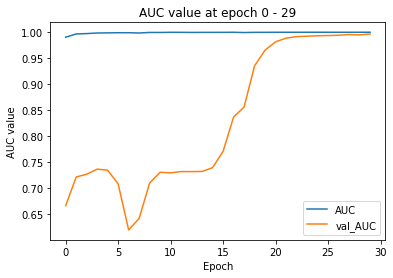

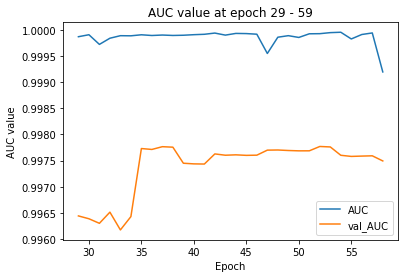

In [47]:
first_title = f'AUC value at epoch 0 - { half_epoch }'
last_title = f'AUC value at epoch { half_epoch } - { len(resnet18_hist_df) }'

titles = [first_title, last_title]

for i in range(2):
    ax = hists[i][['AUC', 'val_AUC']].plot()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC value')
    ax.set_title(titles[i])
plt.show()

In [48]:
evaluate_resnet18 = ft_resnet18.evaluate(test_batches, verbose=1)

78/78 [==============================] - 11s 134ms/step - loss: 0.3876 - TP: 387.0000 - TN: 139.0000 - FP: 95.0000 - FN: 3.0000 - AUC: 0.9791


In [49]:
loss, tp, tn, fp, fn, auc = evaluate_resnet18[0], evaluate_resnet18[1], evaluate_resnet18[2], evaluate_resnet18[3], evaluate_resnet18[4], evaluate_resnet18[5]
print(f'Test loss: { loss }')
print(f'True positive: { tp }')
print(f'True negative: { tn }')
print(f'False positive: { fp }')
print(f'False negative: { fn }')
print('AUC: %.2f' % auc)

Test loss: 0.3876323997974396
True positive: 387.0
True negative: 139.0
False positive: 95.0
False negative: 3.0
AUC: 0.98


# 5. Confusion matrix

In [50]:
from sklearn.metrics import confusion_matrix

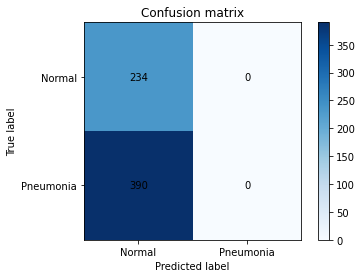

In [52]:
# Create confusion matrix
label = ['Normal', 'Pneumonia']

cm = confusion_matrix(y_true=test_batches.labels,
                      y_pred=np.argmax(ft_resnet18.predict(test_batches), axis=1))

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(label))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j], horizontalalignment='center', verticalalignment='center')
plt.xticks(indexes, label)
plt.xlabel('Predicted label')
plt.yticks(indexes, label)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()